## Importing Libraries

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Importing Data

* Only Considering Opening Price of Stock for making predictions.
* Considering all the historic data is left as experiment for future.

In [2]:
dataset_train= pd.read_csv('../input/google-stock-price/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:,1:2].values

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## Exploratory Data Analysis

<AxesSubplot:xlabel='Date'>

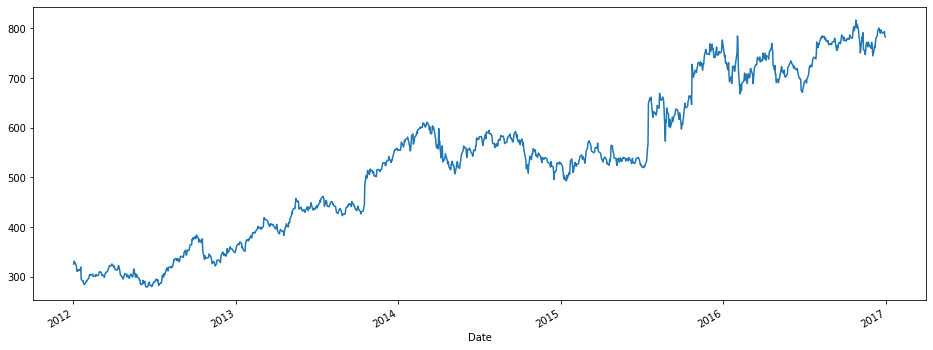

In [5]:
dataset = pd.read_csv('../input/google-stock-price/Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)
dataset['Open'].plot(figsize=(16,6))

## Data Pre-Processing

In [90]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Scaling Opening Prices
* Speeds up computations of Gradient.

In [91]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

### Data Extraction

* t = 50, that is last 50 days of data will be used for computing final opening stock price of day 51.
* note that it is essential that during this step, we EXCLUDE the day of prediction from training set.
* that is   
training set should be stock prices of days [0,50).  
testing set should be stock price at day [50]

In [118]:
def get_training_data(t=50, data = None, ndim = 1, train = True):
    """
    function to extract data of last t days
    t -> last number of days to be considered
    data -> raw training data
    ndim -> number of features to considered
    """
    X_train = []
    y_train = []
    
    rows = data.shape[0]
    for i in range(t,rows):
        ## note that numpy selections are (inclusive,exclusive)
        X_train.append(data[i-t:i])
        if train:
            y_train.append(data[i])
        else:
            y_train.append(-1)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, newshape = (rows-t,ndim,t))
    return X_train, y_train

In [94]:
X_train,y_train = get_training_data(t = 50 , data = training_set_scaled , ndim = 1)

In [95]:
X_train.shape

(1208, 1, 50)

* note that 1 represents only 1 feature being used, that is, opening price
* as mentioned, more features will be used in future experiments

In [96]:
y_train.shape

(1208, 1)

## Model Architectures

### LSTM (Long Short Term Memory) 

In [98]:
def get_LSTM(input_shape = None):
    """
    input_shape[0] = rows
    input_shape[1] = number of dimensions
    input_shape[2] = dimensions of data (t)
    """
    model = tf.keras.Sequential([
        
        ## lstm layer 1
        tf.keras.layers.LSTM(
            units = 50,
            return_sequences=True,
            activation='relu',
            recurrent_activation='sigmoid',
            input_shape = (input_shape[1],input_shape[2])
        ),
        tf.keras.layers.Dropout(0.2),
        
        ##lstm layer 2
        tf.keras.layers.LSTM(
            units = 50,
            return_sequences=True,
            activation='relu',
            recurrent_activation='sigmoid',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## lstm layer 3
        tf.keras.layers.LSTM(
            units = 50,
            return_sequences=True,
            activation='relu',
            recurrent_activation='sigmoid',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## lstm layer 4
        tf.keras.layers.LSTM(
            units = 50,
            return_sequences=True,
            activation='relu',
            recurrent_activation='sigmoid',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## final output layer
        tf.keras.layers.Dense(units=1)
    ]) 
    
    model.compile(
        optimizer = 'adamax',
        loss = 'mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

### Simple RNN (Recurrent Neural Networks)

In [99]:
def get_simple_RNN(input_shape = None):
    """
    input_shape[0] = rows
    input_shape[1] = number of dimensions
    input_shape[2] = dimensions of data (t)
    """
    model = tf.keras.Sequential([
        
        ## RNN layer 1
        tf.keras.layers.SimpleRNN(
            units = 50,
            return_sequences=True,
            activation='relu',
            input_shape = (input_shape[1],input_shape[2])
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## RNN layer 2
        tf.keras.layers.SimpleRNN(
            units = 50,
            return_sequences=True,
            activation='relu',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## RNN layer 3
        tf.keras.layers.SimpleRNN(
            units = 50,
            return_sequences=True,
            activation='relu',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## RNN layer 4
        tf.keras.layers.SimpleRNN(
            units = 50,
            return_sequences=True,
            activation='relu',
        ),
        tf.keras.layers.Dropout(0.2),
        
        ## final output layer
        tf.keras.layers.Dense(units=1)
    ]) 
    
    model.compile(
        optimizer = 'adamax',
        loss = 'mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

## Model Training

### LSTM Training

In [100]:
BATCH_SIZE = 32
EPOCHS = 100

model_lstm = get_LSTM(input_shape = X_train.shape)
history_lstm = model_lstm.fit(
    X_train, 
    y_train, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_split = 0.25
)

Epoch 1/100
29/29 [==============================] - 7s 36ms/step - loss: 0.1515 - root_mean_squared_error: 0.3893 - val_loss: 0.6156 - val_root_mean_squared_error: 0.7846
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0943 - root_mean_squared_error: 0.3071 - val_loss: 0.1658 - val_root_mean_squared_error: 0.4072
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.5392 - val_root_mean_squared_error: 0.7343
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - val_loss: 0.2512 - val_root_mean_squared_error: 0.5012
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.2115 - val_root_mean_squared_error: 0.4599
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.2452 - val_root_

### RNN Training

In [78]:
BATCH_SIZE = 32
EPOCHS = 100

model_simple_RNN = get_simple_RNN(input_shape = X_train.shape)
history_simple_RNN = model_simple_RNN.fit(
    X_train, 
    y_train, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_split = 0.25
)

Epoch 1/100
29/29 [==============================] - 5s 33ms/step - loss: 0.1347 - root_mean_squared_error: 0.3670 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0275 - root_mean_squared_error: 0.1658 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2168
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0185 - root_mean_squared_error: 0.1362 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2158
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0175 - root_mean_squared_error: 0.1325 - val_loss: 0.0579 - val_root_

## Model Comparision

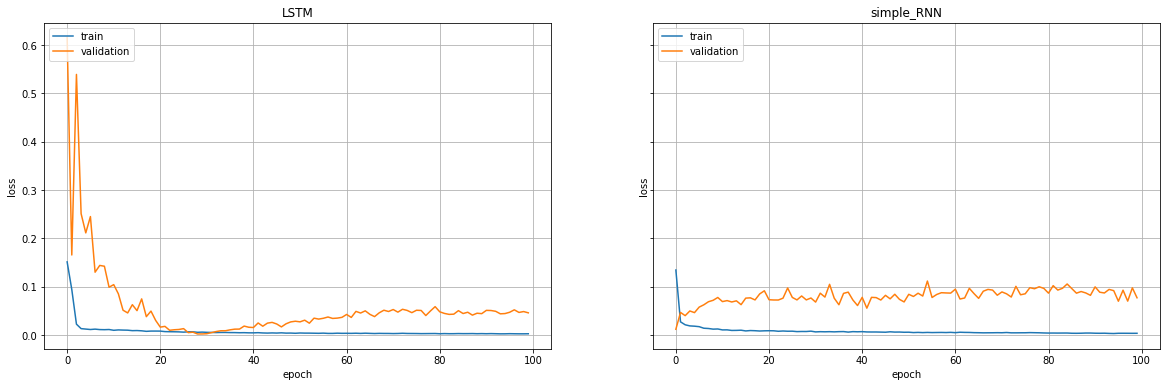

In [101]:
fig, axes = plt.subplots(1,2,figsize=(20,6), sharey = True)
plt.title("LSTM vs Simple RNN")
ax1 , ax2 = axes
 
ax1.plot(history_lstm.history['loss'])
ax1.plot(history_lstm.history['val_loss'])
ax1.set_title('LSTM')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend(['train', 'validation'], loc='upper left')

ax2.plot(history_simple_RNN.history['loss'])
ax2.plot(history_simple_RNN.history['val_loss'])
ax2.set_title('simple_RNN')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend(['train', 'validation'], loc='upper left')


## Conclusion
* RNN reaches an extremely low RMSE of 0.01 at 30 epochs but then starts to overfit the training set, causing it to increase it's overall loss.
* Future experiments of the dataset must involve a callback function to stop training at such instances.
* On the other hand, Simple RNN performs much poor and stabilised at a loss of 0.1 after 20 epochs.
* This is probably caused by a mixture of a being too simple of an architecture to understand dataset and vanishing gradients causing it to not be able to learn anything new.

## Predictions for 2017

### Importing Test Data

In [88]:
dataset_test= pd.read_csv('../input/google-stock-price/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:,1:2].values

In [151]:
dataset_test.shape

(20, 6)

* RNN Needs data for last 50 days, but we have only 20 rows of data
* We need to append last 50 rows of data from testing set to make final predictions

### Data Pre-Processing
* append historic data of last 50 days from train-set
* same pre-processing has to be applied.
* Pipelines would be a more sophisticated way of doing it in future to avoid mistakes

In [153]:
dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']), axis=0)
testing_data = dataset_total[ len(dataset_total) - len(dataset_test) - 50:].values
testing_data = testing_data.reshape(-1,1)

## use the same scaler as training data but only use transform
testing_data = scaler.transform(testing_data)

In [157]:
testing_data.shape

(70, 1)

### Get Data

In [154]:
## call function created earlier but we dont have y_values so use _
X_test,_ = get_training_data(t = 50 , data = testing_data , ndim = 1, train = False)

In [155]:
X_test.shape

(20, 1, 50)

### Make Predictions

#### LSTM

In [158]:
lstm_preds = model_lstm.predict(X_test)
lstm_preds = np.reshape(lstm_preds,newshape=(lstm_preds.shape[0],1))

In [159]:
lstm_preds = scaler.inverse_transform(lstm_preds)

In [160]:
lstm_preds

array([[639.9247 ],
       [639.5506 ],
       [640.04675],
       [640.1728 ],
       [640.0118 ],
       [640.8425 ],
       [641.2663 ],
       [641.6863 ],
       [642.12427],
       [642.15857],
       [641.8784 ],
       [642.0103 ],
       [642.1812 ],
       [642.3937 ],
       [642.772  ],
       [643.20337],
       [643.3115 ],
       [643.63635],
       [643.7805 ],
       [643.9517 ]], dtype=float32)

#### Simple RNN

In [161]:
rnn_preds = model_simple_RNN.predict(X_test)
rnn_preds = np.reshape(rnn_preds,newshape=(rnn_preds.shape[0],1))

In [162]:
rnn_preds = scaler.inverse_transform(rnn_preds)

### Visualizing the Results

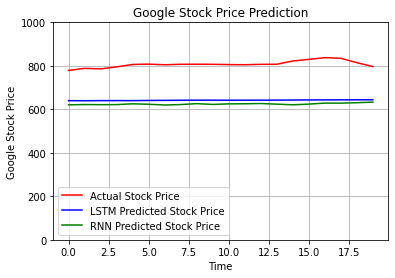

In [163]:
plt.plot(real_stock_price,color='red', label='Actual Stock Price')
plt.plot(lstm_preds,color='blue', label='LSTM Predicted Stock Price')
plt.plot(rnn_preds,color='green', label='RNN Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.ylim(0,1000)
plt.grid()
plt.show()

* Results are not very accurate
* Due to Lack of Features